In [38]:
from nltk.corpus import stopwords
from nltk import word_tokenize,wordpunct_tokenize,wordnet,FreqDist,PorterStemmer
from nltk.tokenize import TweetTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

### Loading Data

In [39]:
df = pd.read_csv("Covid_19_tweets_train.csv",encoding="latin1")
print(df.sample(20)) 

       UserName  ScreenName                Location     TweetAt  \
11010     14809       59761          Lagos, Nigeria  20-03-2020   
1727       5526       50478              Austin, Tx  17-03-2020   
2711       6510       51462                 NDE ???  18-03-2020   
17257     21056       66008       Wichita Falls, TX  23-03-2020   
32667     36466       81418        British Columbia  07-04-2020   
38416     42215       87167  Minneapolis, Minnesota  11-04-2020   
6688      10487       55439        New Delhi, India  19-03-2020   
7412      11211       56163                  London  19-03-2020   
15865     19664       64616                  London  22-03-2020   
9497      13296       58248            New York, NY  20-03-2020   
9847      13646       58598                  London  20-03-2020   
10857     14656       59608        Phoenix, Arizona  20-03-2020   
34284     38083       83035           Essington, Pa  08-04-2020   
9535      13334       58286      Stirling, Scotland  20-03-202

# Data Preprocessing

In [40]:
stop_words = set(stopwords.words("english"))
import string

hashtags = []
def preprocess(text):
    # Lower case
    text = text.lower()
    # remove punct    
    table = str.maketrans('', '', string.punctuation.replace("#",''))
    text = text.translate(table)
    text = text.split()
    hashtags.extend([re.sub("#",'',word) for word in text if "#" in word])
    text = [re.sub("#",'',word) for word in text]
    
    # remove digits and strange symbol 
    text = [re.sub("(\d+|€+)",'',word) for word in text]
    
    # remove urls and empty tweet tags and whitespaces
    text = [word for word in text if re.match(r"^(https)",word) == None and word != "#"]
    text = [word for word in text if word != " "]
    text = " ".join(text)
   
    # remove strange encoding chars
    filters = " ".join(filter(lambda char: char not in string.printable, text))
    if len(filters) > 0:
        text = re.sub(f'[{filters}*]',' ',text)
    
    # tokinaztion
    tokanizer = TweetTokenizer()
    text = tokanizer.tokenize(text)
  
    # remove stopwords and single chars
    text = [t for t in text if t not in stop_words and len(t) > 1]
    lemmatizer = wordnet.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
#     hashtags.extend([word for word in text if "#" in word])
#     stemming
#     stemmer = PorterStemmer()
#     text = [stemmer.stem(w) for w in text]
    
    return " ".join(text)

In [41]:
df["CleanedTweet"] = df["OriginalTweet"].apply(lambda x:preprocess(x))

In [42]:
# remove empty cells 
df["CleanedTweet"].replace('',np.nan,inplace=True)
df.dropna(subset=["CleanedTweet"],inplace=True)
print(df["CleanedTweet"][:200])


0                                                          menyrbie philgahan chrisitv
1      advice talk neighbour family exchange phone number create contact list phone...
2      coronavirus australia woolworth give elderly disabled dedicated shopping hou...
3      food stock one empty please dont panic enough food everyone take need stay c...
4      ready go supermarket covid outbreak im paranoid food stock litteraly empty c...
5      news region first confirmed covid case came sullivan county last week people...
6      cashier grocery store sharing insight covid prove credibility commented im c...
7               supermarket today didnt buy toilet paper rebel toiletpapercrisis covid
8      due covid retail store classroom atlanta open walkin business class next two...
9      corona preventionwe stop buy thing cash use online payment method corona spr...
10     month hasnt crowding supermarket restaurant however reducing hour closing ma...
11     due covid situation increased demand

In [95]:
nan_value = float("NaN")

df["CleanedTweet"].replace("", nan_value, inplace=True)

df["CleanedTweet"].dropna(inplace=True)
df["CleanedTweet"].dropna()

0                                                            menyrbie philgahan chrisitv
1        advice talk neighbour family exchange phone number create contact list phone...
2        coronavirus australia woolworth give elderly disabled dedicated shopping hou...
3        food stock one empty please dont panic enough food everyone take need stay c...
4        ready go supermarket covid outbreak im paranoid food stock litteraly empty c...
5        news region first confirmed covid case came sullivan county last week people...
6        cashier grocery store sharing insight covid prove credibility commented im c...
7                 supermarket today didnt buy toilet paper rebel toiletpapercrisis covid
8        due covid retail store classroom atlanta open walkin business class next two...
9        corona preventionwe stop buy thing cash use online payment method corona spr...
10       month hasnt crowding supermarket restaurant however reducing hour closing ma...
11       due covid si

In [96]:
df["CleanedTweet"].describe()

count                                     41141
unique                                    40934
top       online shopping way covid restriction
freq                                          7
Name: CleanedTweet, dtype: object

In [12]:
df["OriginalTweet"].describe()

count                                                 41141
unique                                                41141
top       When last did you sanitize your hand sanitizer...
freq                                                      1
Name: OriginalTweet, dtype: object

# Text Analysis

In [43]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter


In [44]:
# X_train = data["CleanedTweet"][:int(.75 * len(data["CleanedTweet"]))]
# X_test = data["CleanedTweet"][int(.75 * len(data["CleanedTweet"])):]
X = df["CleanedTweet"]
y = df["Sentiment"]

X_train,X_test,y_train,y_test = train_test_split(X,y)



In [45]:
trigram_cv = CountVectorizer(ngram_range=(1,3),min_df=1)
trigram_cv.fit(X)
vectorizer = trigram_cv.transform(X)

count_list = np.array(vectorizer.sum(axis=0).A1)
word_list = np.array(trigram_cv.get_feature_names())

# most common words
freq_distribution = Counter(dict(zip(word_list, count_list)))
print (freq_distribution.most_common(10))


[('covid', 21816), ('coronavirus', 18021), ('price', 8944), ('store', 8164), ('supermarket', 7734), ('food', 7222), ('grocery', 6737), ('people', 5609), ('consumer', 5169), ('grocery store', 5081)]


In [16]:
freq_df = pd.DataFrame(freq_distribution.most_common(30),columns=['word','count'])
freq_df.head()


word  count
0        covid  21816
1  coronavirus  18021
2        price   8944
3        store   8164
4  supermarket   7734

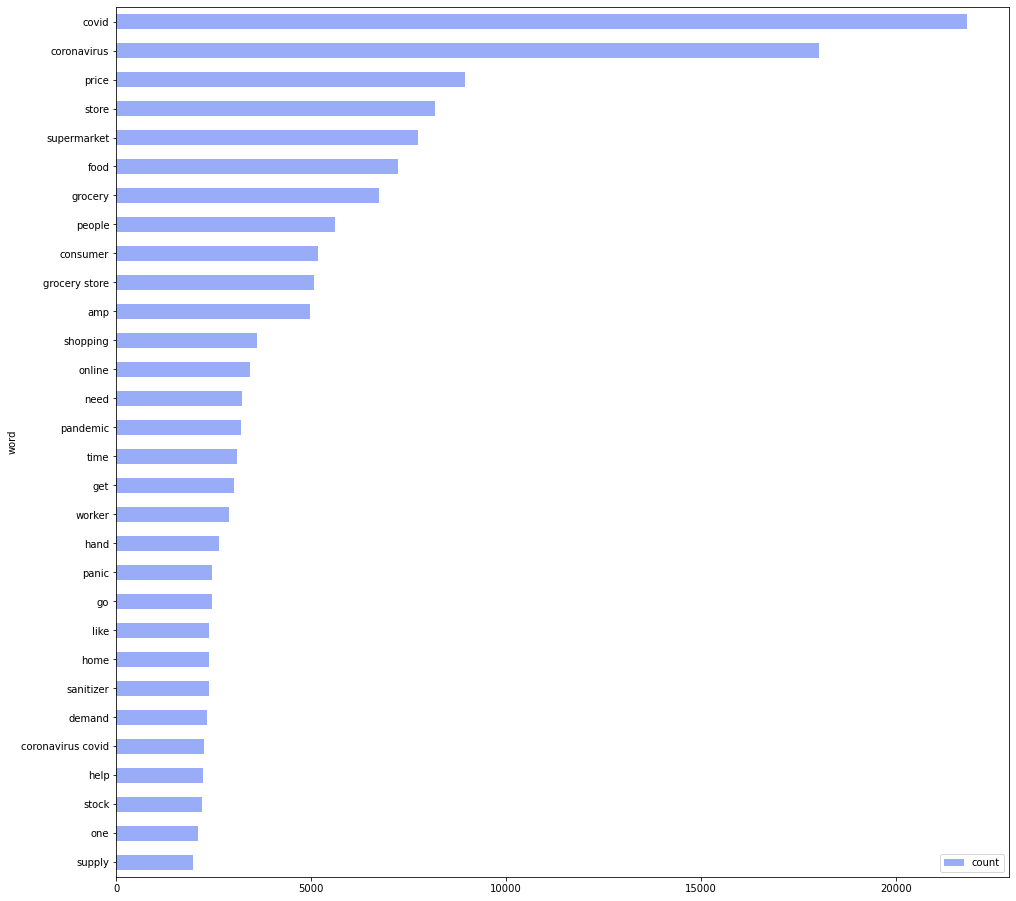

In [17]:
fig, ax = plt.subplots(figsize=(16, 16))
freq_df.sort_values(by='count').plot.barh(
x='word',y='count',ax=ax,color='#98acf8')
plt.show()

# Trending Topics

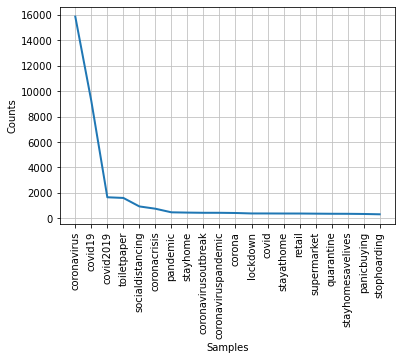

In [18]:
hashtags_freq = FreqDist(hashtags)
hashtags_freq.plot(20)

### remove empty Locations

In [19]:
df.dropna(subset=["Location"],inplace=True)
df["Location"].head(10)

0                        London
1                            UK
2                     Vagabonds
5     ÃT: 36.319708,-82.363649
6          35.926541,-78.753267
7                       Austria
8               Atlanta, GA USA
9              BHAVNAGAR,GUJRAT
10               Makati, Manila
11    Pitt Meadows, BC, Canada 
Name: Location, dtype: object

## plot frequency

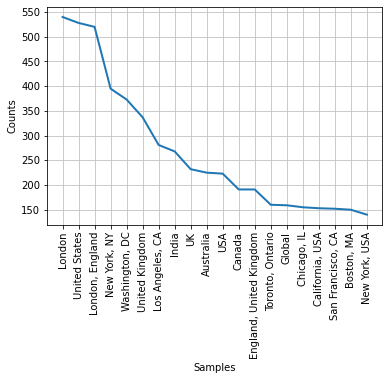

In [20]:
hashtags_freq = FreqDist(df["Location"])
hashtags_freq.plot(20)

In [21]:
pd.set_option('max_rows', None)
pd.set_option("max_colwidth", 80)



# Topic Modeling


In [87]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [88]:
true_k = 3
docs = df["CleanedTweet"]
# count_vec = CountVectorizer(stop_words=stop_words)
# X = count_vec.fit_transform(docs)
# model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# y_kmeans = model.fit_predict(X)
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(docs)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

### trying with K = 3 

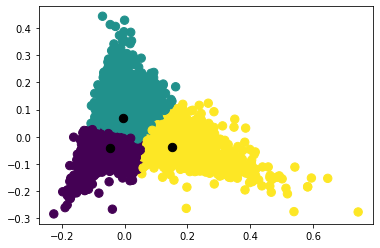

In [113]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1)
fitted = test_e.fit(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(test_e.cluster_centers_[:, 0], test_e.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


# Find best K with Elbow Method

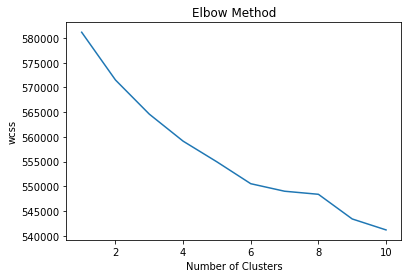

In [26]:



wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()


### Perfect value k = 6

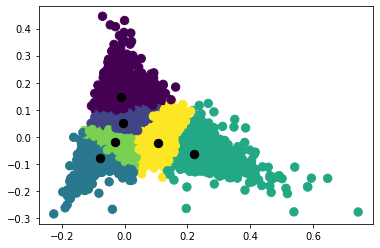

In [110]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= 6 , init='k-means++', max_iter=100, n_init=1)
fitted = kmeans.fit(Y_sklearn)
predicted_values = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


### data starts mixing with k = 8

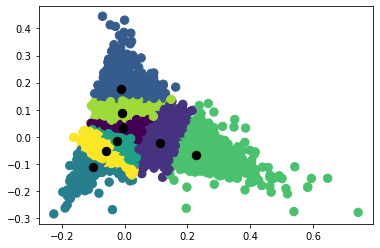

In [114]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= 8 , init='k-means++', max_iter=100, n_init=1)
fitted = kmeans.fit(Y_sklearn)
predicted_values = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


### k = 10

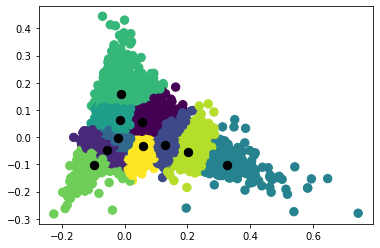

In [115]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= 10 , init='k-means++', max_iter=100, n_init=1)
fitted = kmeans.fit(Y_sklearn)
predicted_values = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


.

.



# Language Models

In [59]:
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline

In [60]:
n = 3
tri_tweet_generator = MLE(3)
train_tweets,padded_sent = padded_everygram_pipeline(n,docs)

In [61]:
tri_tweet_generator.fit(train_tweets,padded_sent)

In [64]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize
def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [71]:
generate_sent(tri_tweet_generator.,200)

'n   d e r m e   h a m i c   o n'

In [90]:
docs = pd.DataFrame(docs)
docs.head(20)

CleanedTweet
0                                                       menyrbie philgahan chrisitv
1   advice talk neighbour family exchange phone number create contact list phone...
2   coronavirus australia woolworth give elderly disabled dedicated shopping hou...
3   food stock one empty please dont panic enough food everyone take need stay c...
4   ready go supermarket covid outbreak im paranoid food stock litteraly empty c...
5   news region first confirmed covid case came sullivan county last week people...
6   cashier grocery store sharing insight covid prove credibility commented im c...
7            supermarket today didnt buy toilet paper rebel toiletpapercrisis covid
8   due covid retail store classroom atlanta open walkin business class next two...
9   corona preventionwe stop buy thing cash use online payment method corona spr...
10  month hasnt crowding supermarket restaurant however reducing hour closing ma...
11  due covid situation increased demand food product wait time may longer onlin...
12  horningsea caring community let look le capable village ensure stay healthy ...
13         dont need stock food ill amazon deliver whatever need coronavirus amazon
14  adara release covid resource center travel brand insight help travel brand s...
15  line grocery store unpredictable eating safe alternative find whether avoidi...
16                                                                                 
17  eyeonthearctic mar russia consumer surveillance watchdog reported case high ...
18  amazon glitch stymy whole food fresh grocery delivery covid spread seen sign...
19  arent struggling please consider donating food bank nonprofit demand service...